In [18]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

In [19]:
np.random.seed(0)

# Parameters and Initialization

In [20]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [21]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [22]:
cache_states = [n*2 for n in range(50)]

# Place activity

In [23]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)

# Cache activity

In [26]:
_, cache_acts, _, cache_acts_over_time = model.run_recurrent(
    place_inputs, n_zero_input=20)

In [39]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[steps, location, :]
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

# Fig 3HJ: Example barcodes

In [41]:
noisy_avg_cache_acts = nb(avg_cache_acts, std_scaling=1.0, mu_scaling=1.0, shift=0.2)
noisy_cache_mean = np.mean(noisy_avg_cache_acts, axis=0)

In [42]:
noisy_place_acts = nb(place_acts, std_scaling=1.0, mu_scaling=1.0, shift=0.2)
noisy_place_mean = np.mean(noisy_place_acts, axis=0).flatten()
noisy_place_std = np.std(noisy_place_acts, axis=0).flatten()

In [43]:
barcodes = []
place_codes = []
for i in range(len(cache_states)):
    location = cache_states[i]
    _cache_act = noisy_avg_cache_acts[i].copy()
    _place_act = noisy_place_acts[location].copy()
    
    # Define barcode
    barcodes.append(_cache_act)
    place_codes.append(_place_act)

3.0


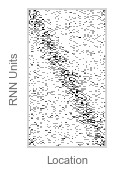

In [47]:
# Chettih et al Figure 3
x = np.array(np.array(place_codes)[:])
fig = plt.figure(figsize=(1.2, 1.8))
im = plt.imshow(
    x.T, cmap='binary',
    interpolation='nearest', aspect='auto')
barcode_maxlim = np.percentile(x, 99)
print(barcode_maxlim)
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.clim(0, barcode_maxlim)
plt.ylabel('RNN Units')
plt.xlabel('Location')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig('figures/fig2h.svg', dpi=300, transparent=True)
plt.show()

3.0


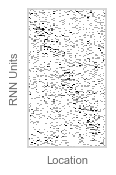

In [45]:
# Chettih et al Figure 3
x = np.array(np.array(barcodes)[:])
fig = plt.figure(figsize=(1.2, 1.8))
im = plt.imshow(
    x.T, cmap='binary',
    interpolation='nearest',
    aspect='auto')
barcode_maxlim = np.percentile(x, 99)
print(barcode_maxlim)
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.clim(0, barcode_maxlim)
plt.ylabel('RNN Units')
plt.xlabel('Location')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig('figures/fig2j.svg', dpi=300, transparent=True)
plt.show()

# Fig3GI: Individual Cells

In [35]:
n_samples = 100

In [36]:
import matplotlib.patches as patches

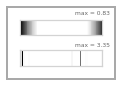

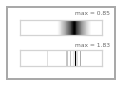

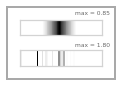

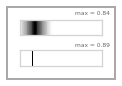

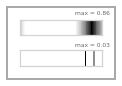

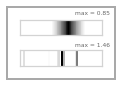

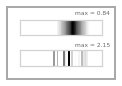

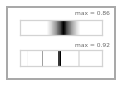

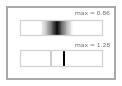

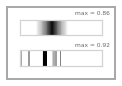

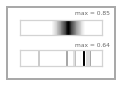

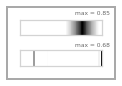

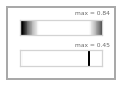

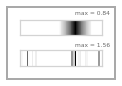

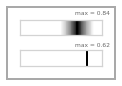

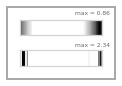

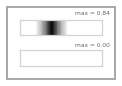

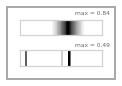

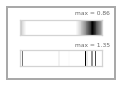

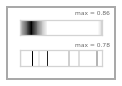

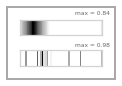

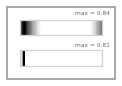

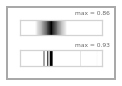

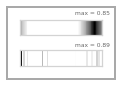

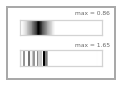

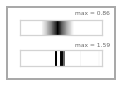

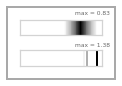

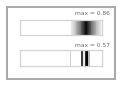

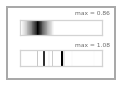

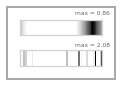

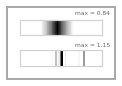

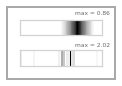

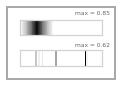

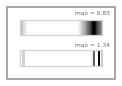

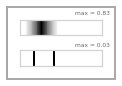

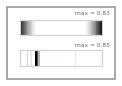

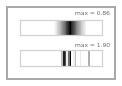

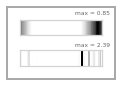

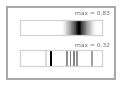

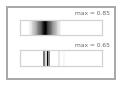

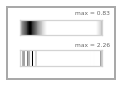

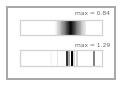

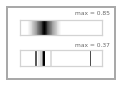

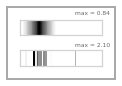

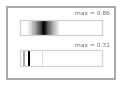

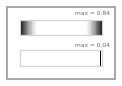

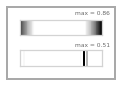

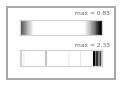

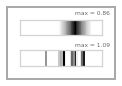

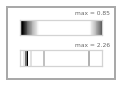

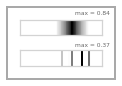

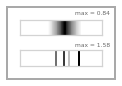

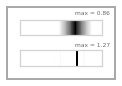

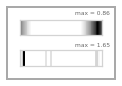

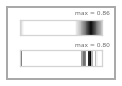

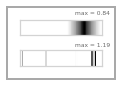

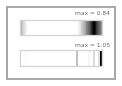

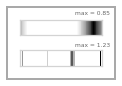

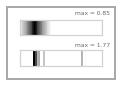

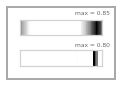

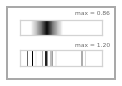

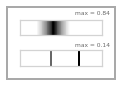

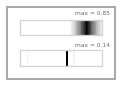

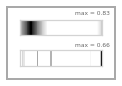

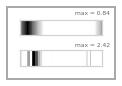

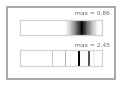

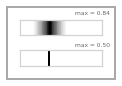

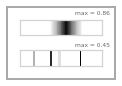

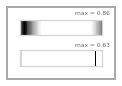

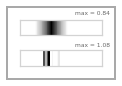

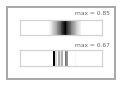

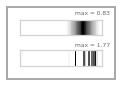

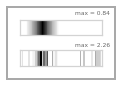

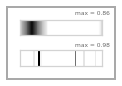

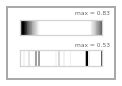

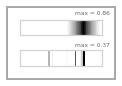

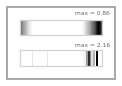

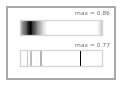

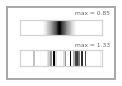

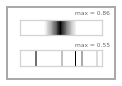

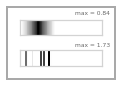

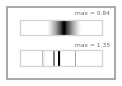

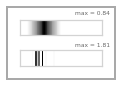

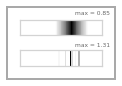

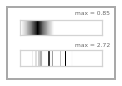

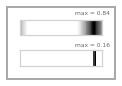

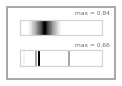

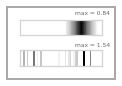

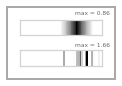

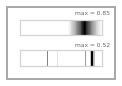

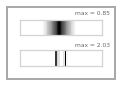

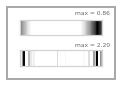

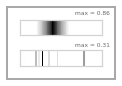

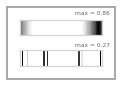

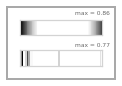

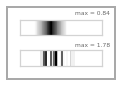

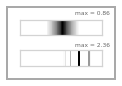

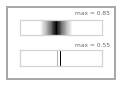

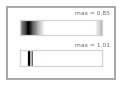

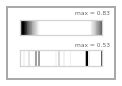

In [39]:
for _ in range(n_samples):
    idx = np.random.choice(N_bar)
    fig, axs = plt.subplots(2, 1, figsize=(1.5, 1.))
    _place_acts = place_acts[:, idx]
    _avg_cache_acts = avg_cache_acts[:, idx]
    place_maxlim = _place_acts.max()
    barcode_maxlim = _avg_cache_acts.max()
    axs[0].imshow(
        _place_acts.reshape((1,-1)),
        aspect='auto', cmap='binary',
        clim=(0, place_maxlim))
    axs[1].imshow(
        _avg_cache_acts.reshape((1,-1)),
        aspect='auto', cmap='binary',
        clim=(0, barcode_maxlim))


    # Add text annotations above the figure with the maximum value
    fig.text(0.95, 0.95, f'max = {place_maxlim:.2f}', 
             ha='right', va='top',
             transform=fig.transFigure, fontsize=6)
    fig.text(0.95, 0.50, f'max = {barcode_maxlim:.2f}', 
             ha='right', va='top',
             transform=fig.transFigure, fontsize=6)
    
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.set_yticks([])
        ax.set_xticks([])
        
    # Add a box around the entire figure
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=fig.transFigure,
        facecolor='none', edgecolor='darkgrey', linewidth=2)
    fig.patches.append(rect)
        
    plt.tight_layout()
    plt.savefig(
        f'figures/default_firing_fields/{idx}.svg',
        dpi=300, transparent=True)
    plt.show()